# Pandera Tutorial

Pandera [documentation](https://pandera.readthedocs.io/en/stable/)

<img src="https://pandera.readthedocs.io/en/stable/_static/pandera-logo.png" style="height:200px">

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import traceback

In [2]:
from utils import setup
baseline, new_data = setup()

## Data Specification

* cat: category "a" or "b"
* feature1: sampled from a uniform distribution ranging from 0 to 1
* feature2: sampled from a uniform distribution ranging from 3 to 4
* feature3: f1<f3<f2
* feature4: sampled from a normal distribution ranging with mean=0 and std=1
* feature5: string that always starts with "k"
* feature6: sampled from two normal distributions, dependending on the value of cat
* feature7: random choice specified by the value of cat
* feature8: string that starts with the value of cat

In [3]:
baseline.head()

,cat,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,b,0.535257,3.217770,1.300862,0.098448,koiov,4.218792,c3,bndjj
1,b,0.904044,3.587250,0.954581,-0.920993,koiov,4.765365,c3,bxcxxv
2,b,0.502397,3.987613,1.499941,0.239369,koiov,4.911374,c2,buopopo
3,b,0.100870,3.950867,0.168542,-2.297608,koiov,5.220988,c3,bndjj
4,a,0.527582,3.342971,0.737048,-0.509211,kdfgdjj,0.462108,c1,axcxxv


In [4]:
new_data.head()

,cat,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,b,0.535257,3.217770,1.300862,3.904632,koiov,-1.284009,c3,bndjj
1,b,0.904044,3.587250,0.954581,-1.681549,koiov,0.142721,c1,bxcxxv
2,b,0.502397,3.987613,1.499941,0.568638,koiov,-1.282885,c1,buopopo
3,b,0.100870,3.950867,0.168542,0.219224,koiov,2.326791,c1,bndjj
4,a,0.527582,3.342971,0.737048,2.799169,kdfgdjj,0.462108,c1,axcxxv


## Features 1-3

Text(0.5, 1.0, 'Sample of Baseline Data Features 1-3')

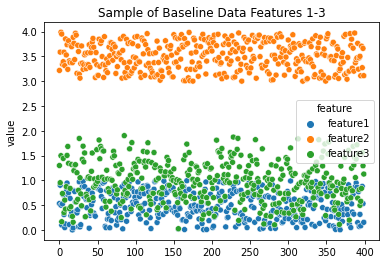

In [5]:
n = 400
temp = baseline.iloc[0:n][["feature1", "feature2", "feature3"]].melt(var_name='feature', value_name='value')
sns.scatterplot(x=list(range(n))*3, y=temp["value"], hue=temp["feature"])
plt.title("Sample of Baseline Data Features 1-3")

Text(0.5, 1.0, 'Sample of New Data Features 1-3')

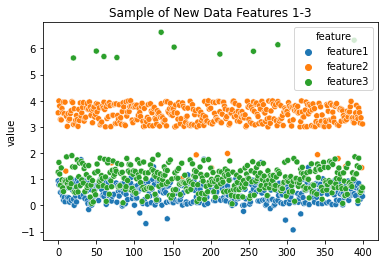

In [6]:
temp = new_data[(new_data["feature3"] < new_data["feature1"]) |
                (new_data["feature3"] > new_data["feature2"]) |
                (new_data["feature1"] > 1) |
                (new_data["feature1"] < 0) |
                (new_data["feature2"] > 4) |
                (new_data["feature2"] < 3)].index

new_list = []
for t in temp:
    new_list.extend(list(range((t-5),(t+5))))
new_list = list(set(new_list)) # deduplication

temp = new_data.iloc[new_list][["feature1", "feature2", "feature3"]].melt(var_name='feature', value_name='value')
sns.scatterplot(x=list(range(len(new_list)))*3, y=temp["value"], hue=temp["feature"])
plt.title("Sample of New Data Features 1-3")

## Feature4

<AxesSubplot:xlabel='feature4', ylabel='Density'>

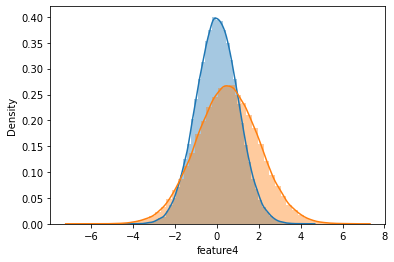

In [7]:
import warnings
warnings.simplefilter("ignore")
plt.figure()
sns.distplot(baseline["feature4"])
sns.distplot(new_data["feature4"])

## Feature 5

In [8]:
print("baseline feature5 starting letter count")
print(baseline['feature5'].str.slice(0,1).value_counts())
print("")
print("new_data feature5 starting letter count")
print(new_data['feature5'].str.slice(0,1).value_counts())

baseline feature5 starting letter count
k    100000
Name: feature5, dtype: int64

new_data feature5 starting letter count
k    99990
p       10
Name: feature5, dtype: int64


## Validation with Pandera

Pandera's design philosophy is currently tied to pandas. In this [Github Issue](https://github.com/pandera-dev/pandera/issues/381), author Niels Bantilan (@cosmicBboy) lays down the design principles of pandera. Copied verbatim, these are:
1. minimize the proliferation of classes in the public-facing API
2. the schema-definition interface should be isomorphic to the data structure being validated i.e. defining a dataframe schema should feel like defining a dataframe
3. prioritize flexibility/expressiveness of validation functions, add built-ins for common checks (based on feature-parity of other similar schema libraries, or by popular request)

In [9]:
import pandera as pa
feature1_check = pa.Column(float, checks=[pa.Check.gt(0), pa.Check.lt(1)], name="feature1")
feature2_check = pa.Column(float, checks=pa.Check.in_range(3,4, include_min=True), name="feature2")
feature1_check.validate(baseline)
feature2_check.validate(baseline)

,cat,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,b,0.535257,3.217770,1.300862,0.098448,koiov,4.218792,c3,bndjj
1,b,0.904044,3.587250,0.954581,-0.920993,koiov,4.765365,c3,bxcxxv
2,b,0.502397,3.987613,1.499941,0.239369,koiov,4.911374,c2,buopopo
3,b,0.100870,3.950867,0.168542,-2.297608,koiov,5.220988,c3,bndjj
4,a,0.527582,3.342971,0.737048,-0.509211,kdfgdjj,0.462108,c1,axcxxv
...,...,...,...,...,...,...,...,...,...
99995,b,0.368663,3.397269,0.379271,0.683929,koiov,5.313297,c2,buopopo
99996,b,0.305073,3.344212,0.382301,-0.495359,kgpo,5.210971,c2,bxcxxv
99997,b,0.214624,3.617771,1.046562,-1.242420,kdfgdjj,4.482330,c2,buopopo
99998,b,0.295777,3.335938,0.538333,0.489144,kdfgdjj,5.451341,c2,buopopo


In [10]:
try:
    feature1_check.validate(new_data)
except Exception:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_84893/3043545787.py", line 2, in <module>
    feature1_check.validate(new_data)
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schema_components.py", line 232, in validate
    validate_column(check_obj, column_name)
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schema_components.py", line 205, in validate_column
    super(Column, copy(self).set_name(column_name)).validate(
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 1996, in validate
    error_handler.collect_error("dataframe_check", err)
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/error_handlers.py", line 32, in collect_error
    raise schema_error from original_exc
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 1991, in validate
    _handle_check_results(
  File "/opt/minic

## DataFrameSchema

In [11]:
 schema = pa.DataFrameSchema(
    {
        "feature1": pa.Column(float, checks=[pa.Check.gt(0), pa.Check.lt(1)], nullable=False),
        "feature2": feature2_check,
        "feature5": pa.Column(str, pa.Check.str_startswith("k"), coerce=True),
        "feature10": pa.Column(str, pa.Check.str_startswith("k"), required=False)
    }
)
schema.validate(baseline)

,cat,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,b,0.535257,3.217770,1.300862,0.098448,koiov,4.218792,c3,bndjj
1,b,0.904044,3.587250,0.954581,-0.920993,koiov,4.765365,c3,bxcxxv
2,b,0.502397,3.987613,1.499941,0.239369,koiov,4.911374,c2,buopopo
3,b,0.100870,3.950867,0.168542,-2.297608,koiov,5.220988,c3,bndjj
4,a,0.527582,3.342971,0.737048,-0.509211,kdfgdjj,0.462108,c1,axcxxv
...,...,...,...,...,...,...,...,...,...
99995,b,0.368663,3.397269,0.379271,0.683929,koiov,5.313297,c2,buopopo
99996,b,0.305073,3.344212,0.382301,-0.495359,kgpo,5.210971,c2,bxcxxv
99997,b,0.214624,3.617771,1.046562,-1.242420,kdfgdjj,4.482330,c2,buopopo
99998,b,0.295777,3.335938,0.538333,0.489144,kdfgdjj,5.451341,c2,buopopo


There is a bit to unpack there so we'll go over it.
1. The validate() method returns the DataFrame if there are no errors
2. nullable=False is the check to make sure the values are not null
3. We can also pass a pa.Column object directly. In the example above, we passed feature2_check.
4. coerce=True in feature5 forces the data to become str
5. required=False means that the column does not have to be in the DataFrame

## DataFrame-level Checks

In [12]:
wide_schema = pa.DataFrameSchema(
    columns={
        "feature1": pa.Column(float, checks=[pa.Check.gt(0), pa.Check.lt(1)], nullable=False),
        "feature2": feature2_check,
    },
    # define checks at the DataFrameSchema-level
    checks=pa.Check(
        lambda df: (df["feature3"] > df["feature1"]) & (df['feature3'] < df['feature2']),
        name="feature3_between"
    )
)

# Using the ; to hide the output
wide_schema.validate(baseline);

In [13]:
try:
    wide_schema.validate(new_data)
except Exception:
    traceback.print_exc()

Traceback (most recent call last):
  File "/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_84893/1196453640.py", line 2, in <module>
    wide_schema.validate(new_data)
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 519, in validate
    return self._validate(
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 693, in _validate
    error_handler.collect_error("schema_component_check", err)
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/error_handlers.py", line 32, in collect_error
    raise schema_error from original_exc
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 685, in _validate
    result = schema_component(
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schemas.py", line 2038, in __call__
    return self.validate(
  File "/opt/miniconda3/envs/orion/lib/python3.8/site-packages/pandera/schema_components.

## Lazy Validation

In [14]:
try:
    wide_schema.validate(new_data, lazy=True)
except pa.errors.SchemaErrors as err:
    print("Schema errors and failure cases:")
    print(err.failure_cases.head)
    print("\nDataFrame object that failed validation:")
    print(err.data.head())

Schema errors and failure cases:
<bound method NDFrame.head of      schema_context    column             check check_number failure_case  \
65  DataFrameSchema  feature2  feature3_between            0     3.496897   
66  DataFrameSchema  feature2  feature3_between            0     3.797014   
96  DataFrameSchema  feature5  feature3_between            0        koiov   
95  DataFrameSchema  feature5  feature3_between            0         kgpo   
94  DataFrameSchema  feature5  feature3_between            0         kgpo   
..              ...       ...               ...          ...          ...   
26           Column  feature2      not_nullable         None          NaN   
25           Column  feature2      not_nullable         None          NaN   
24           Column  feature2      not_nullable         None          NaN   
23           Column  feature2      not_nullable         None          NaN   
0            Column  feature1   greater_than(0)            0    -0.511062   

    index  


## Custom Validator

In [15]:
schema = pa.DataFrameSchema({
    # a vectorized check that returns a bool
    "feature1": pa.Column(float, pa.Check(lambda s: s.mean() < 0, element_wise=False)),
    # a vectorized check that returns a boolean Series
    "feature2": pa.Column(float, pa.Check(lambda s: s > 0, element_wise=False)),
    # an element-wise check that returns a bool
    "feature5": pa.Column(str, pa.Check(lambda x: False, element_wise=True)),
})

try:
    schema.validate(baseline, lazy=True)
except pa.errors.SchemaErrors as err:
    print(err.failure_cases.head)

<bound method NDFrame.head of    schema_context    column     check  check_number failure_case index
0          Column  feature1  <lambda>             0        False  None
1          Column  feature5  <lambda>             0        koiov     0
2          Column  feature5  <lambda>             0        koiov     1
3          Column  feature5  <lambda>             0        koiov     2
4          Column  feature5  <lambda>             0        koiov     3
5          Column  feature5  <lambda>             0      kdfgdjj     4
6          Column  feature5  <lambda>             0      kdfgdjj     5
7          Column  feature5  <lambda>             0      kdfgdjj     6
8          Column  feature5  <lambda>             0      kdfgdjj     7
9          Column  feature5  <lambda>             0      kdfgdjj     8
10         Column  feature5  <lambda>             0        koiov     9>


## Decorator Usage

From the Pandera [documentation](https://pandera.readthedocs.io/en/stable/decorators.html?highlight=decorator)

In [16]:
from pandera import check_input, check_output, check_io
df = pd.DataFrame({
   "column1": [1, 4, 0, 10, 9],
   "column2": [-1.3, -1.4, -2.9, -10.1, -20.4],
})

in_schema = pa.DataFrameSchema({
   "column1": pa.Column(int,
                     pa.Check(lambda x: 0 <= x <= 10, element_wise=True)),
   "column2": pa.Column(float, pa.Check(lambda x: x < -1.2)),
})

out_schema = pa.DataFrameSchema({
   "column1": pa.Column(int,
                     pa.Check(lambda x: 0 <= x <= 10, element_wise=True)),
   "column2": pa.Column(float, pa.Check(lambda x: x < -1.2)),
})

# by default, check_input assumes that the first argument is
# dataframe/series.
@check_input(in_schema)
def preprocessor(dataframe):
    dataframe["column3"] = dataframe["column1"] + dataframe["column2"]
    return dataframe

# by default assumes that the pandas DataFrame/Schema is the only output
@check_output(out_schema)
def zero_column_1(df):
    df["column1"] = 0
    return df

check_io(df1=in_schema, df2=in_schema, out=out_schema)
def zero_column_1(df):
    df["column1"] = 0
    return df